In [115]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [116]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [117]:
import os
import pandas as pd

BASOPHIL_dirs = [r'//kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Basophil']

EOSINOPHIL_dirs = [
    r'/kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Eosinophil'
]

LYMPHOCYTE_dir = [ r'/kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Lymphocyte']

MONOCYTE_dirs = [
    r'/kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Monocyte'
]

NEUTROPHIL_dirs = [
    r'/kaggle/input/wbcv4-no-augmentation-randomrotate/wbcv4_no_augmentation_randomRotate/Neutrophil'
]

filepaths = []
labels = []
dict_lists = [BASOPHIL_dirs, EOSINOPHIL_dirs, LYMPHOCYTE_dir, MONOCYTE_dirs, NEUTROPHIL_dirs]
class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths    labels
0  //kaggle/input/wbcv4-no-augmentation-randomrot...  BASOPHIL
1  //kaggle/input/wbcv4-no-augmentation-randomrot...  BASOPHIL
2  //kaggle/input/wbcv4-no-augmentation-randomrot...  BASOPHIL
3  //kaggle/input/wbcv4-no-augmentation-randomrot...  BASOPHIL
4  //kaggle/input/wbcv4-no-augmentation-randomrot...  BASOPHIL
labels
NEUTROPHIL    6231
LYMPHOCYTE    2427
EOSINOPHIL    2132
MONOCYTE      1590
BASOPHIL       602
Name: count, dtype: int64


In [118]:
bloodCell_df.shape

(12982, 2)

In [119]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(bloodCell_df, test_size=0.2, random_state=42)

In [120]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(10385, 2)
(3895, 2)
(2597, 2)
(9087, 2)


In [121]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=8,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )

Found 10385 validated image filenames belonging to 5 classes.
Found 3895 validated image filenames belonging to 5 classes.
Found 2597 validated image filenames belonging to 5 classes.


In [122]:
classes=list(train.class_indices.keys())
print (classes)

['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


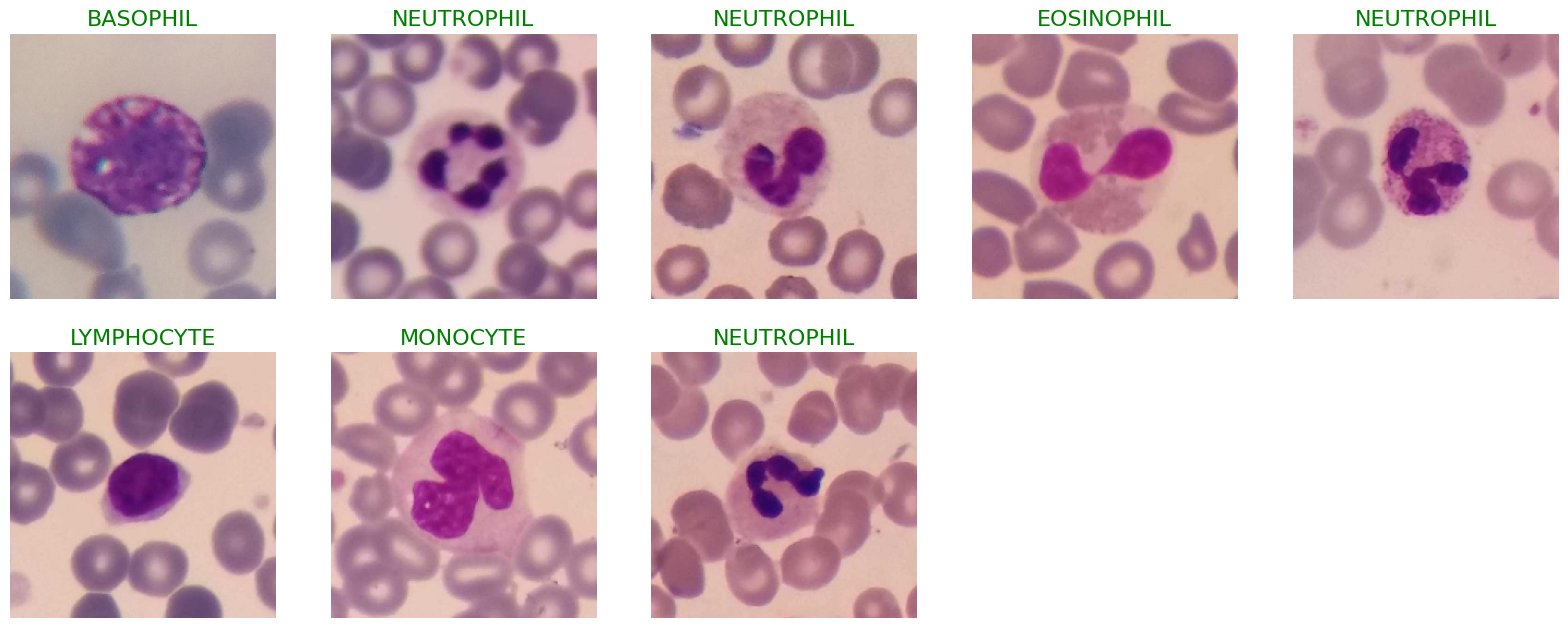

In [123]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [124]:
import tensorflow as tf
from tensorflow import keras

height, width, channels = 244, 244, 3  # Input image dimensions

# Define the CNN model with attention
inputs = tf.keras.layers.Input(shape=(height, width, channels))

# Convolutional layers for feature extraction
x = keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu')(inputs)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3, 3))(x)

x = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2))(x)

# Flatten the feature maps
flattened = keras.layers.Flatten()(x)

# Attention mechanism
attention_weights = keras.layers.Dense(units=512, activation="softmax")(flattened)  # Compute attention weights
attention_output = keras.layers.Multiply()([x, attention_weights[:, None, None, :]])  # Apply attention to feature maps

# Fully connected layers for classification
x = keras.layers.Flatten()(attention_output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

# Model definition
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 79, 79,    │     24,704 │ input_layer_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 79, 79,    │        512 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 79, 79,    │    819,456 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 79, 79,    │      1,024 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 26, 26,    │    590,080 │ max_pooling2d_24… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 26, 26,    │     65,792 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 26, 26,    │     65,792 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      1,024 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 26, 26,    │  1,180,160 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │      2,048 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 13, 13,    │  2,359,808 │ max_pooling2d_25… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │      2,048 │ conv2d_60[0][0] 

 Total params: 17,972,357 (68.56 MB)

 Trainable params: 17,965,957 (68.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

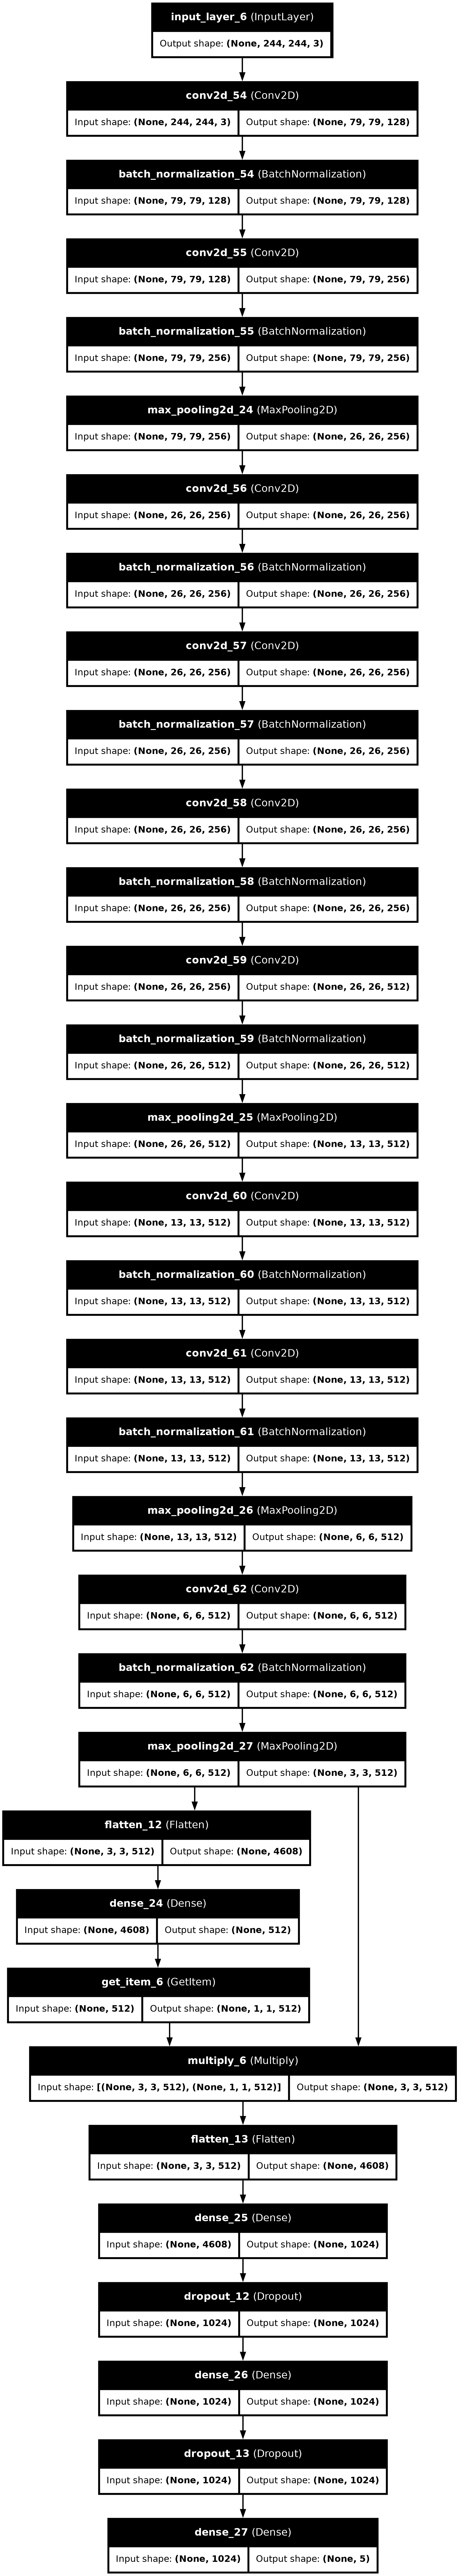

In [125]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [126]:
history = model.fit(train, epochs=30, validation_data=val, verbose=1)

Epoch 1/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 65s 45ms/step - accuracy: 0.4273 - loss: 1.3204 - val_accuracy: 0.5930 - val_loss: 0.9166
Epoch 2/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.6228 - loss: 0.8836 - val_accuracy: 0.7201 - val_loss: 0.7026
Epoch 3/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.7578 - loss: 0.6591 - val_accuracy: 0.7774 - val_loss: 0.6068
Epoch 4/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.7908 - loss: 0.5681 - val_accuracy: 0.7874 - val_loss: 0.5446
Epoch 5/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.7883 - loss: 0.5178 - val_accuracy: 0.7994 - val_loss: 0.4622
Epoch 6/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.8111 - loss: 0.4442 - val_accuracy: 0.8290 - val_loss: 0.4331
Epoch 7/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - accuracy: 0.8573 - loss: 0.3613 - val_accuracy: 0.8749 - val_loss: 0.3415
Epoch 8/30
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.9034 -

In [127]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

1299/1299 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - accuracy: 0.9998 - loss: 0.0041 - val_accuracy: 0.9626 - val_loss: 0.1680


In [128]:
model.evaluate(test, verbose=1)

487/487 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9657 - loss: 0.1580


[0.11303340643644333, 0.9745827913284302]

In [129]:
model.save("Blood Cell.h5")

In [130]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

487/487 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step


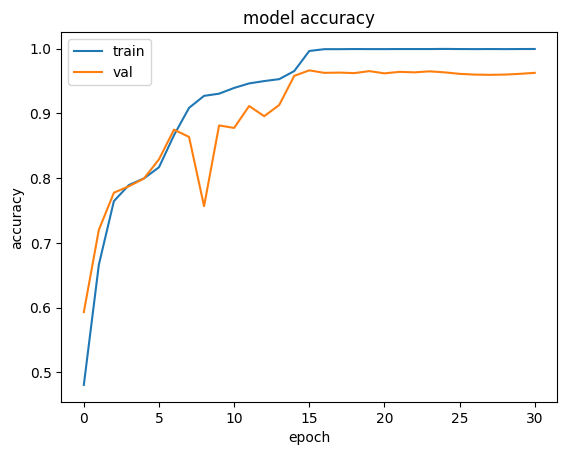

In [131]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

    BASOPHIL       0.92      1.00      0.96       186
  EOSINOPHIL       0.96      0.98      0.97       633
  LYMPHOCYTE       0.98      0.97      0.97       746
    MONOCYTE       0.93      0.94      0.93       488
  NEUTROPHIL       1.00      0.98      0.99      1842

    accuracy                           0.97      3895
   macro avg       0.96      0.97      0.96      3895
weighted avg       0.98      0.97      0.97      3895

Accuracy of the Model: 97.5%


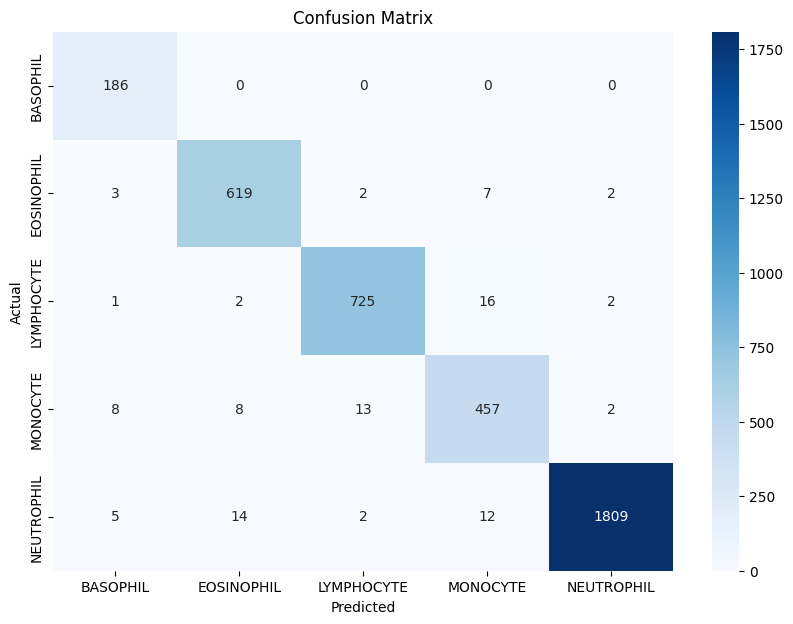

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['BASOPHIL','EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5,4.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()